In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

Loading models...

KNN predicted neighbor indices and distances
[[ 7585  7586  7587  7584  7582]
 [ 9620  9619  9618  9617  9622]
 [ 8517  8514  8513  8518  8512]
 ...
 [15435 15432 15437 15434 15436]
 [  621   624   625   618   619]
 [ 7591  7590  7592  7589  7588]] [[ 9.17380715  9.50379419  9.64084972 18.43311908 56.70785764]
 [ 9.25670886 17.04688527 43.27945395 45.8781772  52.31159515]
 [ 8.31443615 27.33823457 30.84301711 32.28434809 47.80880497]
 ...
 [ 6.87765147 23.25312669 46.37535856 46.82641338 48.75762453]
 [ 9.96958591 10.79583471 11.67219258 11.91547038 12.08733908]
 [ 8.63806738 20.82508352 21.13124255 45.64741149 49.85699708]]


Evaluating models...

--- Logistic Regression Model Evaluation ---
Accuracy: 0.7478
Precision: 0.8778
Recall: 0.7478
F1 Score: 0.7893
ROC-AUC: 0.8179

--- XGBoost Model Evaluation ---
Accuracy: 0.9198
Precision: 0.9119
Recall: 0.9198
F1 Score: 0.9121
ROC-AUC: 0.9128

Results saved to 'model_comparison_results.csv
'


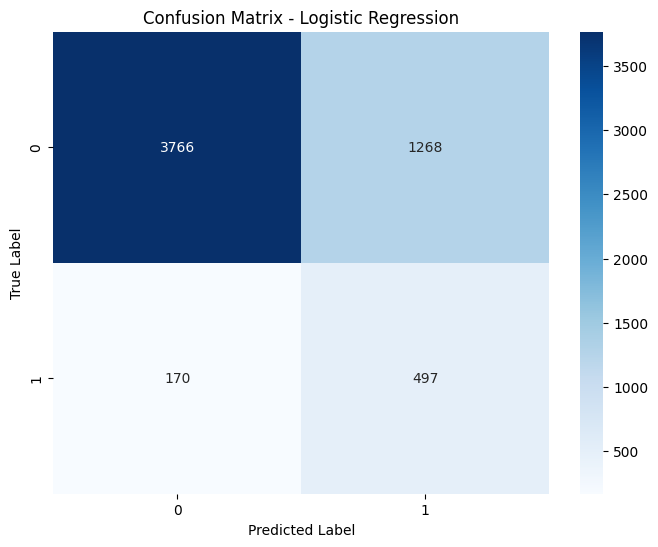

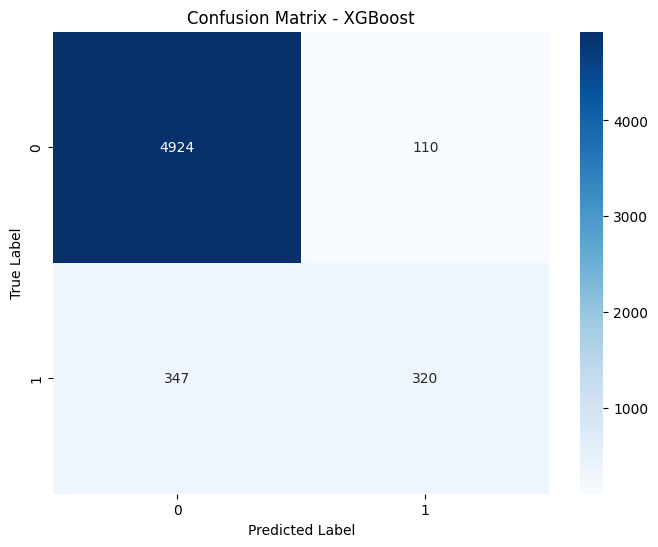

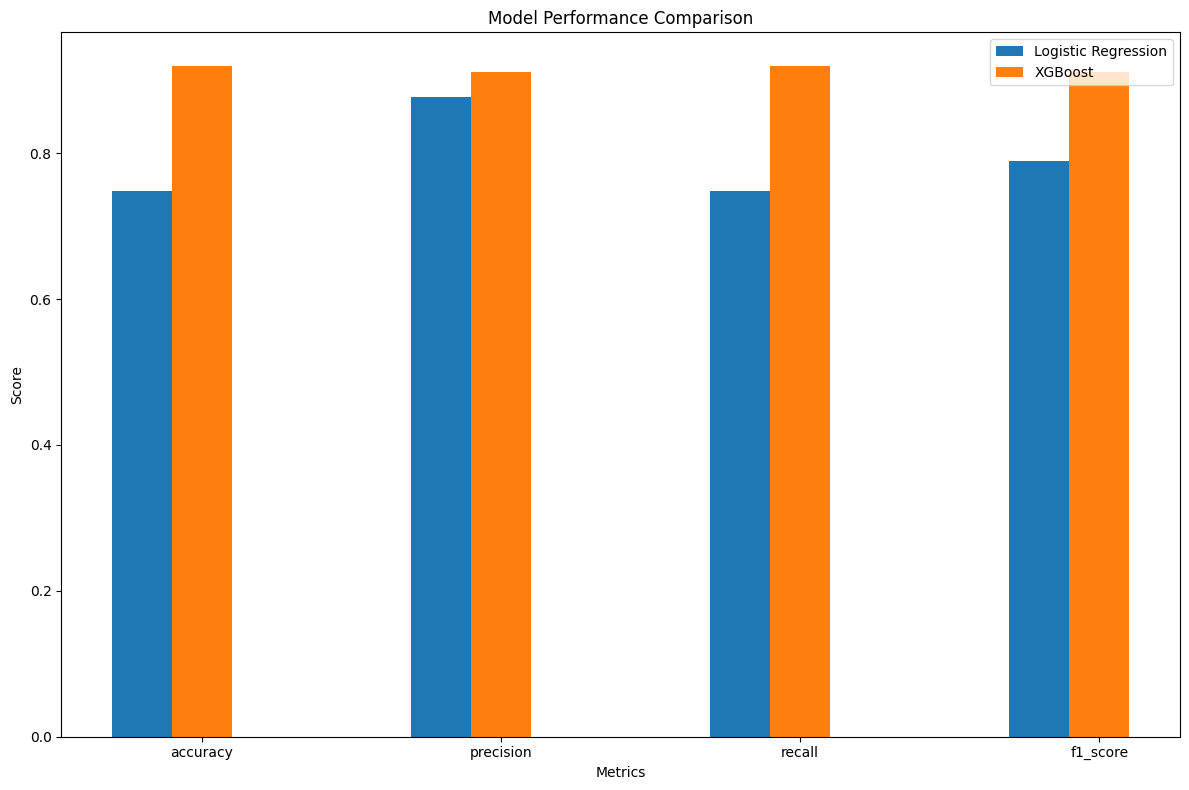


Evaluation complete!


In [2]:
# Load the saved models
print("Loading models...")
logistic_model = joblib.load('models/logistic_regression_model.pkl')
xgboost_model = joblib.load('models/xgboost_classifier.pkl')
knn_model = joblib.load('models/knn_recommender_model.pkl')

# Load the test data
test_data = pd.read_csv('data_splits/test_data.csv')
test_data.drop(columns=['language', 'movie_name'], inplace = True)

# Assuming the last column is the target variable
X_test = test_data.drop('rating', axis=1)
y_test = test_data['rating']
y_test = (y_test >= 7).astype(int)

import warnings
warnings.filterwarnings('ignore')

# Make predictions with each model
logistic_pred = logistic_model.predict(X_test)
xgboost_pred = xgboost_model.predict(X_test)
distances, indices = knn_model.kneighbors(test_data, n_neighbors=5)

# Dispaly the neearest neighbors indices and distances
print("\nKNN predicted neighbor indices and distances")
print(indices, distances)
print()

# For ROC-AUC, we need probability predictions
logistic_proba = logistic_model.predict_proba(X_test)[:, 1]
xgboost_proba = xgboost_model.predict_proba(X_test)[:, 1]
# knn_proba = knn_model.predict_proba(X_test)[:, 1]

# Function to calculate and display metrics
def evaluate_model(y_true, y_pred, y_proba, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Try to calculate ROC-AUC, but handle multiclass scenario
    try:
        auc = roc_auc_score(y_true, y_proba)
    except Exception as e:
        print(f"Could not calculate ROC-AUC for {model_name}: {e}")
        auc = None

    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n--- {model_name} Model Evaluation ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"ROC-AUC: {auc:.4f}")
    
    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'figures/{model_name}_confusion_matrix.png')
    
    return {
        'model': model_name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': auc
    }

# Evaluate each model
print("\nEvaluating models...")
logistic_results = evaluate_model(y_test, logistic_pred, logistic_proba, 'Logistic Regression')
xgboost_results = evaluate_model(y_test, xgboost_pred, xgboost_proba, 'XGBoost')

# Combine results for comparison
all_results = [logistic_results, xgboost_results]
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to 'model_comparison_results.csv\n'")

# Create comparison bar chart
plt.figure(figsize=(12, 8))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
bar_width = 0.2
x = np.arange(len(metrics))

plt.bar(x - bar_width, [logistic_results[m] for m in metrics], width=bar_width, label='Logistic Regression')
plt.bar(x, [xgboost_results[m] for m in metrics], width=bar_width, label='XGBoost')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison_chart.png')
plt.show()

print("\nEvaluation complete!")

In [3]:
import pandas as pd
import joblib
from sklearn.metrics import silhouette_score

# Load Data
df = pd.read_csv("models/kmeans_model_files/movies_with_kmeans.csv")
X = pd.read_csv("models/kmeans_model_files/kmeans_features.csv")
hdbscan_df = pd.read_csv("models/hdbscan_model_files/movies_with_hdbscan.csv")

# Load Models
scaler = joblib.load("models/kmeans_model_files/kmeans_scaler.pkl")
knn_model = joblib.load("models/knn_model_files/knn_model.pkl")
kmeans_model = joblib.load("models/kmeans_model_files/kmeans_model.pkl")
hdbscan_model = joblib.load("models/hdbscan_model_files/hdbscan_model.pkl")

# Silhouette Score for KMeans
if 'kmeans_cluster' in df.columns:
    kmeans_silhouette = silhouette_score(X, df['kmeans_cluster'])
    print(f"\nSilhouette Score [KMeans]: {kmeans_silhouette:.4f}")

# Silhouette Score for HDBSCAN (excluding noise points -1)
if 'hdbscan_cluster' in hdbscan_df.columns:
    mask = hdbscan_df['hdbscan_cluster'] != -1
    if hdbscan_df[mask]['hdbscan_cluster'].nunique() > 1:
        hdbscan_silhouette = silhouette_score(X[mask], hdbscan_df[mask]['hdbscan_cluster'])
        print(f"Silhouette Score [HDBSCAN]: {hdbscan_silhouette:.4f}")
    else:
        print("HDBSCAN: Not enough clusters (excluding noise) to calculate silhouette score.")

# Helper function to calculate genre overlapping
def genre_overlap(base_idx, compare_indices):
    base = set(df.loc[base_idx, 'genres_raw'].split(','))
    scores = []
    for i in compare_indices:
        compare = set(df.loc[i, 'genres_raw'].split(','))
        jaccard = len(base & compare) / len(base | compare)
        scores.append(jaccard)
    return sum(scores) / len(scores) if scores else 0

# Evaluation function
def evaluate_models(movie_title, top_n=5):
    idx = df[df['title'].str.lower() == movie_title.lower()].index
    if len(idx) == 0:
        print(f"Movie '{movie_title}' not found.")
        return

    idx = idx[0]
    query_vector = X.iloc[[idx]]

    print(f"\nEvaluation for: {df.loc[idx, 'title']}")
    print("--------------------------------------------------")

    # KNN
    _, knn_indices = knn_model.kneighbors(query_vector, n_neighbors=top_n+1)
    knn_indices = knn_indices[0][1:]
    knn_score = genre_overlap(idx, knn_indices)
    for i in knn_indices:
        print(f"→ {df.loc[i, 'title']} ({df.loc[i, 'year']})")
    print(f"\n[KNN] Avg Genre Overlap: {knn_score:.3f}\n")

    # KMeans
    kmeans_label = kmeans_model.predict(query_vector)[0]
    kmeans_group = df[df['kmeans_cluster'] == kmeans_label]['title'].tolist()
    print(f"\n[KMeans] Same cluster ID: {kmeans_label}")
    print(f"→ {min(top_n, len(kmeans_group))} sample movies from this cluster:")
    for title in kmeans_group[:top_n]:
        print(f"   • {title}")
    
    kmeans_indices = df[df['kmeans_cluster'] == kmeans_label].index.tolist()
    kmeans_indices = [i for i in kmeans_indices if i != idx][:top_n]
    kmeans_score = genre_overlap(idx, kmeans_indices)
    print(f"\n[KMeans] Avg Genre Overlap: {kmeans_score:.3f}\n")

    # HDBSCAN
    hdbscan_label = hdbscan_model.labels_[idx]
    if hdbscan_label == -1:
        print(f"\n[HDBSCAN] Noise Point (No valid cluster)\n")
        hdbscan_score = 0.0
    else:
        hdb_group = hdbscan_df[hdbscan_df['hdbscan_cluster'] == hdbscan_label]['title'].tolist()
        print(f"→ {min(top_n, len(hdb_group))} sample movies from this cluster:")
        for title in hdb_group[:top_n]:
            print(f"   • {title}")
        hdbscan_indices = hdbscan_df[hdbscan_df['hdbscan_cluster'] == hdbscan_label].index.tolist()
        hdbscan_indices = [i for i in hdbscan_indices if i != idx][:top_n]
        hdbscan_score = genre_overlap(idx, hdbscan_indices)
        print(f"\n[HDBSCAN] Avg Genre Overlap: {hdbscan_score:.3f}\n")

    return {
        'title': movie_title,
        'knn_score': knn_score,
        'kmeans_score': kmeans_score,
        'hdbscan_score': hdbscan_score
    }

# Run evaluation
test_movies = ["The Godfather", "Inception", "Titanic"]
results = []

for movie in test_movies:
    result = evaluate_models(movie)
    print("*" * 120)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)
print("\n\nFinal Evaluation Summary:\n")
print(results_df)



Silhouette Score [KMeans]: 0.2213
Silhouette Score [HDBSCAN]: 0.8599

Evaluation for: The Godfather
--------------------------------------------------
→ The Gambler (1974)
→ American History X (1998)
→ Scarface (1983)
→ Gangs of New York (2002)
→ American Hustle (2013)

[KNN] Avg Genre Overlap: 1.000


[KMeans] Same cluster ID: 4
→ 5 sample movies from this cluster:
   • Casino
   • Dead Man Walking
   • To Die For
   • Bottle Rocket
   • Headless Body in Topless Bar

[KMeans] Avg Genre Overlap: 0.800


[HDBSCAN] Noise Point (No valid cluster)

************************************************************************************************************************

Evaluation for: Inception
--------------------------------------------------
→ Avengers: Infinity War (2018)
→ Mad Max: Fury Road (2015)
→ Star Wars: Episode VII - The Force Awakens (2015)
→ The Hunger Games (2012)
→ Avengers: Age of Ultron (2015)

[KNN] Avg Genre Overlap: 1.000


[KMeans] Same cluster ID: 20
→ 5 sample movi